In [122]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
!pip install inflect
import os
os.environ["KAGGLE_USERNAME"]="krutuparnaparanjape"
os.environ["KAGGLE_KEY"]="cbe10b9c8831315c006d661298debd20"



In [123]:
!pip install kaggle
import inflect

### Read Data

In [136]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Data analysis

###  Make dummy if Doctor/Advocate is present in name and another dummy if constituency is reseved for SC/ST


In [130]:

df['is_advocate'] = df['Candidate'].str.contains('Adv.', case=False).astype(int)
df['is_doctor'] = df['Candidate'].str.contains('Dr.', case=False).astype(int)
df['is_SC'] = df['Constituency ∇'].str.contains('(SC)', case=False).astype(int)
df['is_ST'] = df['Constituency ∇'].str.contains('(ST)', case=False).astype(int)


df_test['is_advocate'] = df_test['Candidate'].str.contains('Adv.', case=False).astype(int)
df_test['is_doctor'] = df_test['Candidate'].str.contains('Dr.', case=False).astype(int)
df_test['is_SC'] = df_test['Constituency ∇'].str.contains('(SC)', case=False).astype(int)
df_test['is_ST'] = df_test['Constituency ∇'].str.contains('(ST)', case=False).astype(int)
df.head()

C:\Users\krutu\AppData\Local\Temp/ipykernel_9284/4089470128.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['is_SC'] = df['Constituency ∇'].str.contains('(SC)', case=False).astype(int)
C:\Users\krutu\AppData\Local\Temp/ipykernel_9284/4089470128.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['is_ST'] = df['Constituency ∇'].str.contains('(ST)', case=False).astype(int)
C:\Users\krutu\AppData\Local\Temp/ipykernel_9284/4089470128.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_test['is_SC'] = df_test['Constituency ∇'].str.contains('(SC)', case=False).astype(int)
C:\Users\krutu\AppData\Local\Temp/ipykernel_9284/4089470128.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_test['is_ST'] = df_test['Constituency ∇'].str.contains('(ST)', case=False).astype(int)


,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,is_advocate,is_doctor,is_SC,is_ST
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass,0,0,0,0
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass,0,0,1,0
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate,0,1,0,0
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate,0,0,0,0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass,0,0,1,0


In [127]:
df_test.shape

(1374, 8)

### Extract Numerical values from Assets & Liabilities

In [131]:
import math
def text_to_number(text):
    words = text.split()
    number = 0
    i = 0
    while i < len(words)-1:
        num = int(words[i])
        unit = words[i + 1]
        if unit == 'Crore+':
            number += (num * 10**7)
        elif unit == 'Lac+':
            number += (num * 10**5)
        elif unit == 'Thou+':
            number += (num * 10**3)
        elif unit == 'Hund+':
            number += (num * 10**2)
        else:
            raise ValueError("Unknown unit")
        i += 2
    return number

# Apply the function to the DataFrame column
df['Liabilities'] = df['Liabilities'].apply(text_to_number)
df['Total Assets'] = df['Total Assets'].apply(text_to_number)
df_test['Liabilities'] = df_test['Liabilities'].apply(text_to_number)
df_test['Total Assets'] = df_test['Total Assets'].apply(text_to_number)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# df[['Total Assets', 'Liabilities']] = scaler.fit_transform(df[['Total Assets', 'Liabilities']])
# df_test[['Total Assets', 'Liabilities']] = scaler.transform(df_test[['Total Assets', 'Liabilities']])

### Drop columns with very low Information gain

In [112]:
df.drop(columns = ['Candidate','Constituency ∇','ID'],axis=1, inplace = True)
df_test.drop(columns = ['Candidate','Constituency ∇','ID'],axis=1, inplace = True)

### Data Analysis

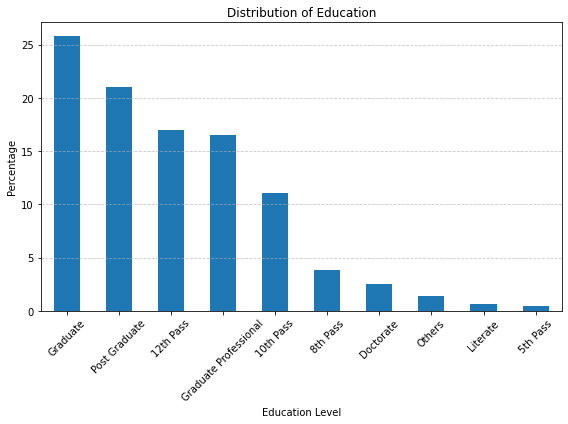

In [137]:
education_distribution = df['Education'].value_counts(normalize=True) * 100

# Plotting the distribution
plt.figure(figsize=(8, 6))
education_distribution.plot(kind='bar')
plt.title('Distribution of Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

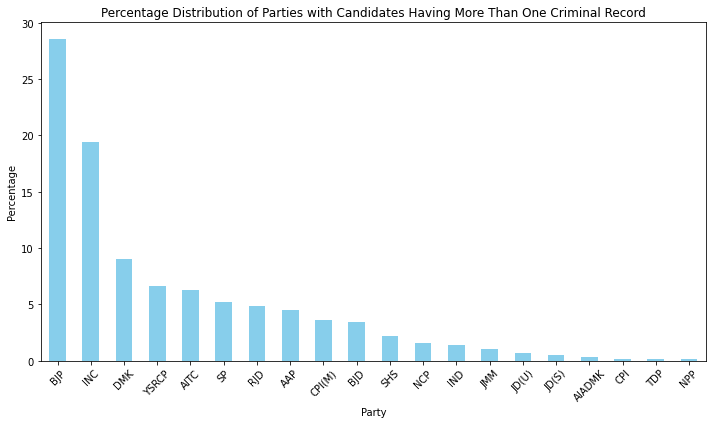

In [129]:
import matplotlib.pyplot as plt
df_more_than_one = df[df['Criminal Case'] > 1]

# Calculate percentage distribution of parties
party_distribution = df_more_than_one['Party'].value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(10, 6))
party_distribution.plot(kind='bar', color='skyblue')
plt.title('Percentage Distribution of Parties with Candidates Having More Than One Criminal Record')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

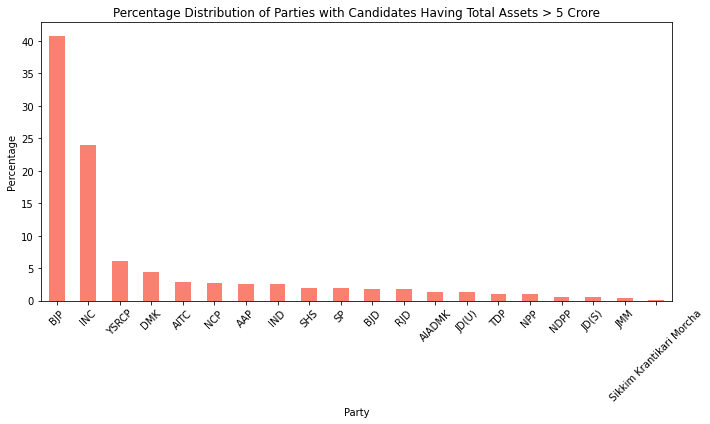

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame df
# Example DataFrame structure:
# df = pd.DataFrame({'party': ['A', 'B', 'C', 'A', 'B', 'C'],
#                    'total_assets': [1000000, 75000000, 6000000, 30000000, 4000000, 90000000]})

# Filter candidates with 'Total Assets' greater than 5 crore
df_assets_greater_than_5cr = df[df['Total Assets'] > 50000000]  # Assuming 1 crore = 10000000

# Calculate percentage distribution of parties
party_distribution = df_assets_greater_than_5cr['Party'].value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(10, 6))
party_distribution.plot(kind='bar', color='salmon')
plt.title('Percentage Distribution of Parties with Candidates Having Total Assets > 5 Crore')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


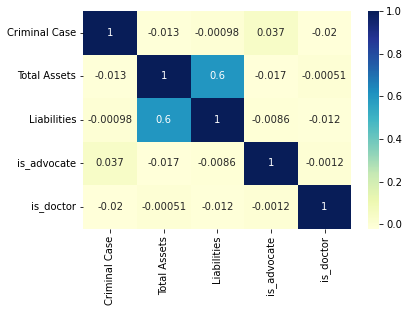

In [9]:
import seaborn as sb 
  
# plotting correlation heatmap 
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)

### Oversampling using CTGAN

In [113]:
!pip install ctgan
from ctgan import CTGAN
metadata = {
    'Party': 'categorical',
    'Total Assets': 'numerical',
    'Liabilities': 'numerical',
    'state': 'categorical',
    'is_advocate' : 'numerical',
    "is_doctor" : 'numerical',
    'is_SC' : 'numerical',
    'is_ST' : 'numerical',
    'Education' : 'categorical'
    # Add more columns and their types as needed
}

#Train the CTGAN model
ctgan = CTGAN(epochs=10)
ctgan.fit(df, metadata)
synthetic_data = ctgan.sample(500)
df = pd.concat([df,synthetic_data],axis=0)

In [114]:
# Construct X_train, y_train and X_test
X_train = df.drop(columns = ['Education'], axis=1)
y_train = df['Education']

X_test = df_test
X_test.head()

,Party,Criminal Case,Total Assets,Liabilities,state,is_advocate,is_doctor,is_SC,is_ST
0,IND,2,0.055249,0.012486,MAHARASHTRA,0,0,0,0
1,AITC,1,0.001579,0.000148,WEST BENGAL,0,0,0,0
2,NCP,3,0.038674,0.001135,MAHARASHTRA,0,0,0,0
3,AITC,1,0.001579,0.000000,WEST BENGAL,0,0,0,0
4,SP,0,0.012628,0.002270,UTTAR PRADESH,0,0,0,0


### One-Hot Encoding columns : 'Party' and 'State'

In [115]:
categorical_columns = ['Party','state']
X_train_encoded = pd.get_dummies(X_train, columns = categorical_columns)
X_test_encoded = pd.get_dummies(X_test, columns = categorical_columns)
X_train_encoded.drop(columns = [ 'Criminal Case', 'Total Assets', 'Liabilities','is_doctor','is_advocate','is_SC','is_ST'], axis=1,inplace=True)
X_test_encoded.drop(columns = ['Criminal Case', 'Total Assets', 'Liabilities','is_doctor','is_advocate','is_SC','is_ST'], axis=1,inplace=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_train.drop(columns = ['state', 'Party'], axis=1,inplace=True)
X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_test.drop(columns = ['state', 'Party'], axis=1,inplace=True)

In [117]:
X_train

,Criminal Case,Total Assets,Liabilities,is_advocate,is_doctor,is_SC,is_ST,Party_AAP,Party_AIADMK,Party_AITC,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,4,0.166535,0.002270,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0.000789,0.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.005525,0.000250,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.007103,0.000272,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0.001579,0.000692,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0.000260,0.000999,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,1,0.008682,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0.000039,0.000795,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
498,0,0.000134,0.000545,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Trying Different Classifiers

In [63]:
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=10)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8 9], got ['10th Pass' '12th Pass' '5th Pass' '8th Pass' 'Doctorate' 'Graduate'
 'Graduate Professional' 'Literate' 'Others' 'Post Graduate']

In [37]:
#X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier()

# Train the model using the training sets

rf_classifier.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = rf_classifier.predict(X_test)
# accuracy = accuracy_score(y_test1, y_pred)
# print(accuracy)

In [118]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate the Bernoulli Naive Bayes model
model = BernoulliNB()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_pred_bnb = model.predict(X_test)

In [96]:
from sklearn.neighbors import KNeighborsClassifier
k = 50
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn_classifier.predict(X_test)


### Generating Predictions 

In [119]:
df_pred = pd.DataFrame(y_pred_bnb)
df_pred.head()

,0
0,10th Pass
1,12th Pass
2,Graduate
3,12th Pass
4,Post Graduate


In [120]:
csv_file = 'submission14.csv'
df_pred.to_csv(csv_file,index_label='ID',header='Education')